# Post Processing and Visualization

Professional PyVista visualization for 24 vertebrae labels (C1-C7, T1-T12, L1-L5) from SuPreM predictions

In [24]:
# ── Import Required Libraries ────────────────────────────────────────────
import os
import numpy as np
import nibabel as nib
import pyvista as pv
from skimage import measure

In [25]:
# ── Define Vertebrae Color Mapping ──────────────────────────────────────
VERTEBRAE_COLORS = {
    # Cervical (C1-C7)
    1: '#FF0000',    # C1 - Red
    2: '#FF4500',    # C2 - Orange Red
    3: '#FF8C00',    # C3 - Dark Orange
    4: '#FFD700',    # C4 - Gold
    5: '#ADFF2F',    # C5 - Green Yellow
    6: '#00FF00',    # C6 - Green
    7: '#00CED1',    # C7 - Dark Turquoise
    # Thoracic (T1-T12)
    8: '#1E90FF',    # T1 - Dodger Blue
    9: '#0000FF',    # T2 - Blue
    10: '#8A2BE2',   # T3 - Blue Violet
    11: '#9400D3',   # T4 - Dark Violet
    12: '#FF00FF',   # T5 - Magenta
    13: '#FF1493',   # T6 - Deep Pink
    14: '#DC143C',   # T7 - Crimson
    15: '#8B4513',   # T8 - Saddle Brown
    16: '#D2691E',   # T9 - Chocolate
    17: '#CD853F',   # T10 - Peru
    18: '#DEB887',   # T11 - Burlywood
    19: '#F0E68C',   # T12 - Khaki
    # Lumbar (L1-L5)
    20: '#808000',   # L1 - Olive
    21: '#556B2F',   # L2 - Dark Olive Green
    22: '#228B22',   # L3 - Forest Green
    23: '#008080',   # L4 - Teal
    24: '#4682B4'    # L5 - Steel Blue
}

VERTEBRAE_NAMES = {
    1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7',
    8: 'T1', 9: 'T2', 10: 'T3', 11: 'T4', 12: 'T5', 13: 'T6',
    14: 'T7', 15: 'T8', 16: 'T9', 17: 'T10', 18: 'T11', 19: 'T12',
    20: 'L1', 21: 'L2', 22: 'L3', 23: 'L4', 24: 'L5'
}

In [27]:
# ── Load Patient Segmentation Data ──────────────────────────────────────
# Select patient
patient_id = "BDMAP_00000031"  # Change to "BDMAP_00000006" for the other patient

nii_path = f"{patient_id}/combined_labels.nii.gz"
print(f"Loading: {nii_path}")

nii = nib.load(nii_path)
labels = nii.get_fdata().astype(np.uint8)

print(f"Data shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")

Loading: BDMAP_00000031/combined_labels.nii.gz
Data shape: (301, 276, 651)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [30]:
# ── Setup High-Resolution Plotter ───────────────────────────────────────
# Create off-screen plotter for publication-quality rendering
p = pv.Plotter(off_screen=True, window_size=(3000, 3000))
p.set_background('white')

print("Plotter initialized with 3000x3000 resolution")

Plotter initialized with 3000x3000 resolution


In [31]:
# ── Extract and Render All 24 Vertebrae ────────────────────────────────
unique_labels = sorted(set(np.unique(labels)) - {0})

for label_value in unique_labels:
    vertebra_name = VERTEBRAE_NAMES.get(label_value, f"Label_{label_value}")
    print(f"Extracting {vertebra_name} (label {label_value})...", end=' ')
    
    # Create mask for this vertebra
    mask = (labels == label_value).astype(np.uint8)
    
    # Extract surface mesh using marching cubes
    verts, faces, normals, values = measure.marching_cubes(mask, level=0.5)
    
    # Convert faces to VTK format: [n_pts, v0, v1, v2, ...]
    faces = np.hstack([np.full((faces.shape[0], 1), 3), faces]).astype(np.int64)
    
    # Build PyVista mesh
    mesh = pv.PolyData(verts, faces)
    
    # Apply smoothing for cleaner surface
    mesh = mesh.smooth(n_iter=50, relaxation_factor=0.1)
    
    # Decimate to reduce polygon count (optional, for faster rendering)
    mesh = mesh.decimate(target_reduction=0.5)
    
    # Get color for this vertebra
    color = VERTEBRAE_COLORS.get(label_value, '#CCCCCC')
    
    # Add mesh to plotter with material properties
    p.add_mesh(
        mesh,
        color=color,
        name=vertebra_name,
        smooth_shading=True,
        specular=1.0,
        specular_power=30,
        show_edges=False
    )
    
    # print(f"✓ ({len(verts)} vertices)")

print(f"\nTotal vertebrae rendered: {len(unique_labels)}")

Extracting C1 (label 1)... Extracting C2 (label 2)... Extracting C3 (label 3)... Extracting C4 (label 4)... Extracting C5 (label 5)... Extracting C6 (label 6)... Extracting C7 (label 7)... Extracting T1 (label 8)... Extracting T2 (label 9)... Extracting T3 (label 10)... Extracting T4 (label 11)... Extracting T5 (label 12)... Extracting T6 (label 13)... Extracting T7 (label 14)... Extracting T8 (label 15)... Extracting T9 (label 16)... Extracting T10 (label 17)... Extracting T11 (label 18)... Extracting T12 (label 19)... Extracting L1 (label 20)... Extracting L2 (label 21)... Extracting L3 (label 22)... Extracting L4 (label 23)... Extracting L5 (label 24)... 
Total vertebrae rendered: 24


In [32]:
# ── Configure Professional Lighting ──────────────────────────────────────
# Add main light source
light = pv.Light(
    position=(1, 1, 1),
    focal_point=p.camera.focal_point,
    color='white',
    intensity=1.3
)
p.add_light(light)

print("Lighting configured")

Lighting configured


In [33]:
# ── Position Camera and Frame Scene ──────────────────────────────────────
# Automatically center and zoom to fit all vertebrae
p.reset_camera()

print("Camera positioned for optimal view")

Camera positioned for optimal view


c:\Users\nikhi\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


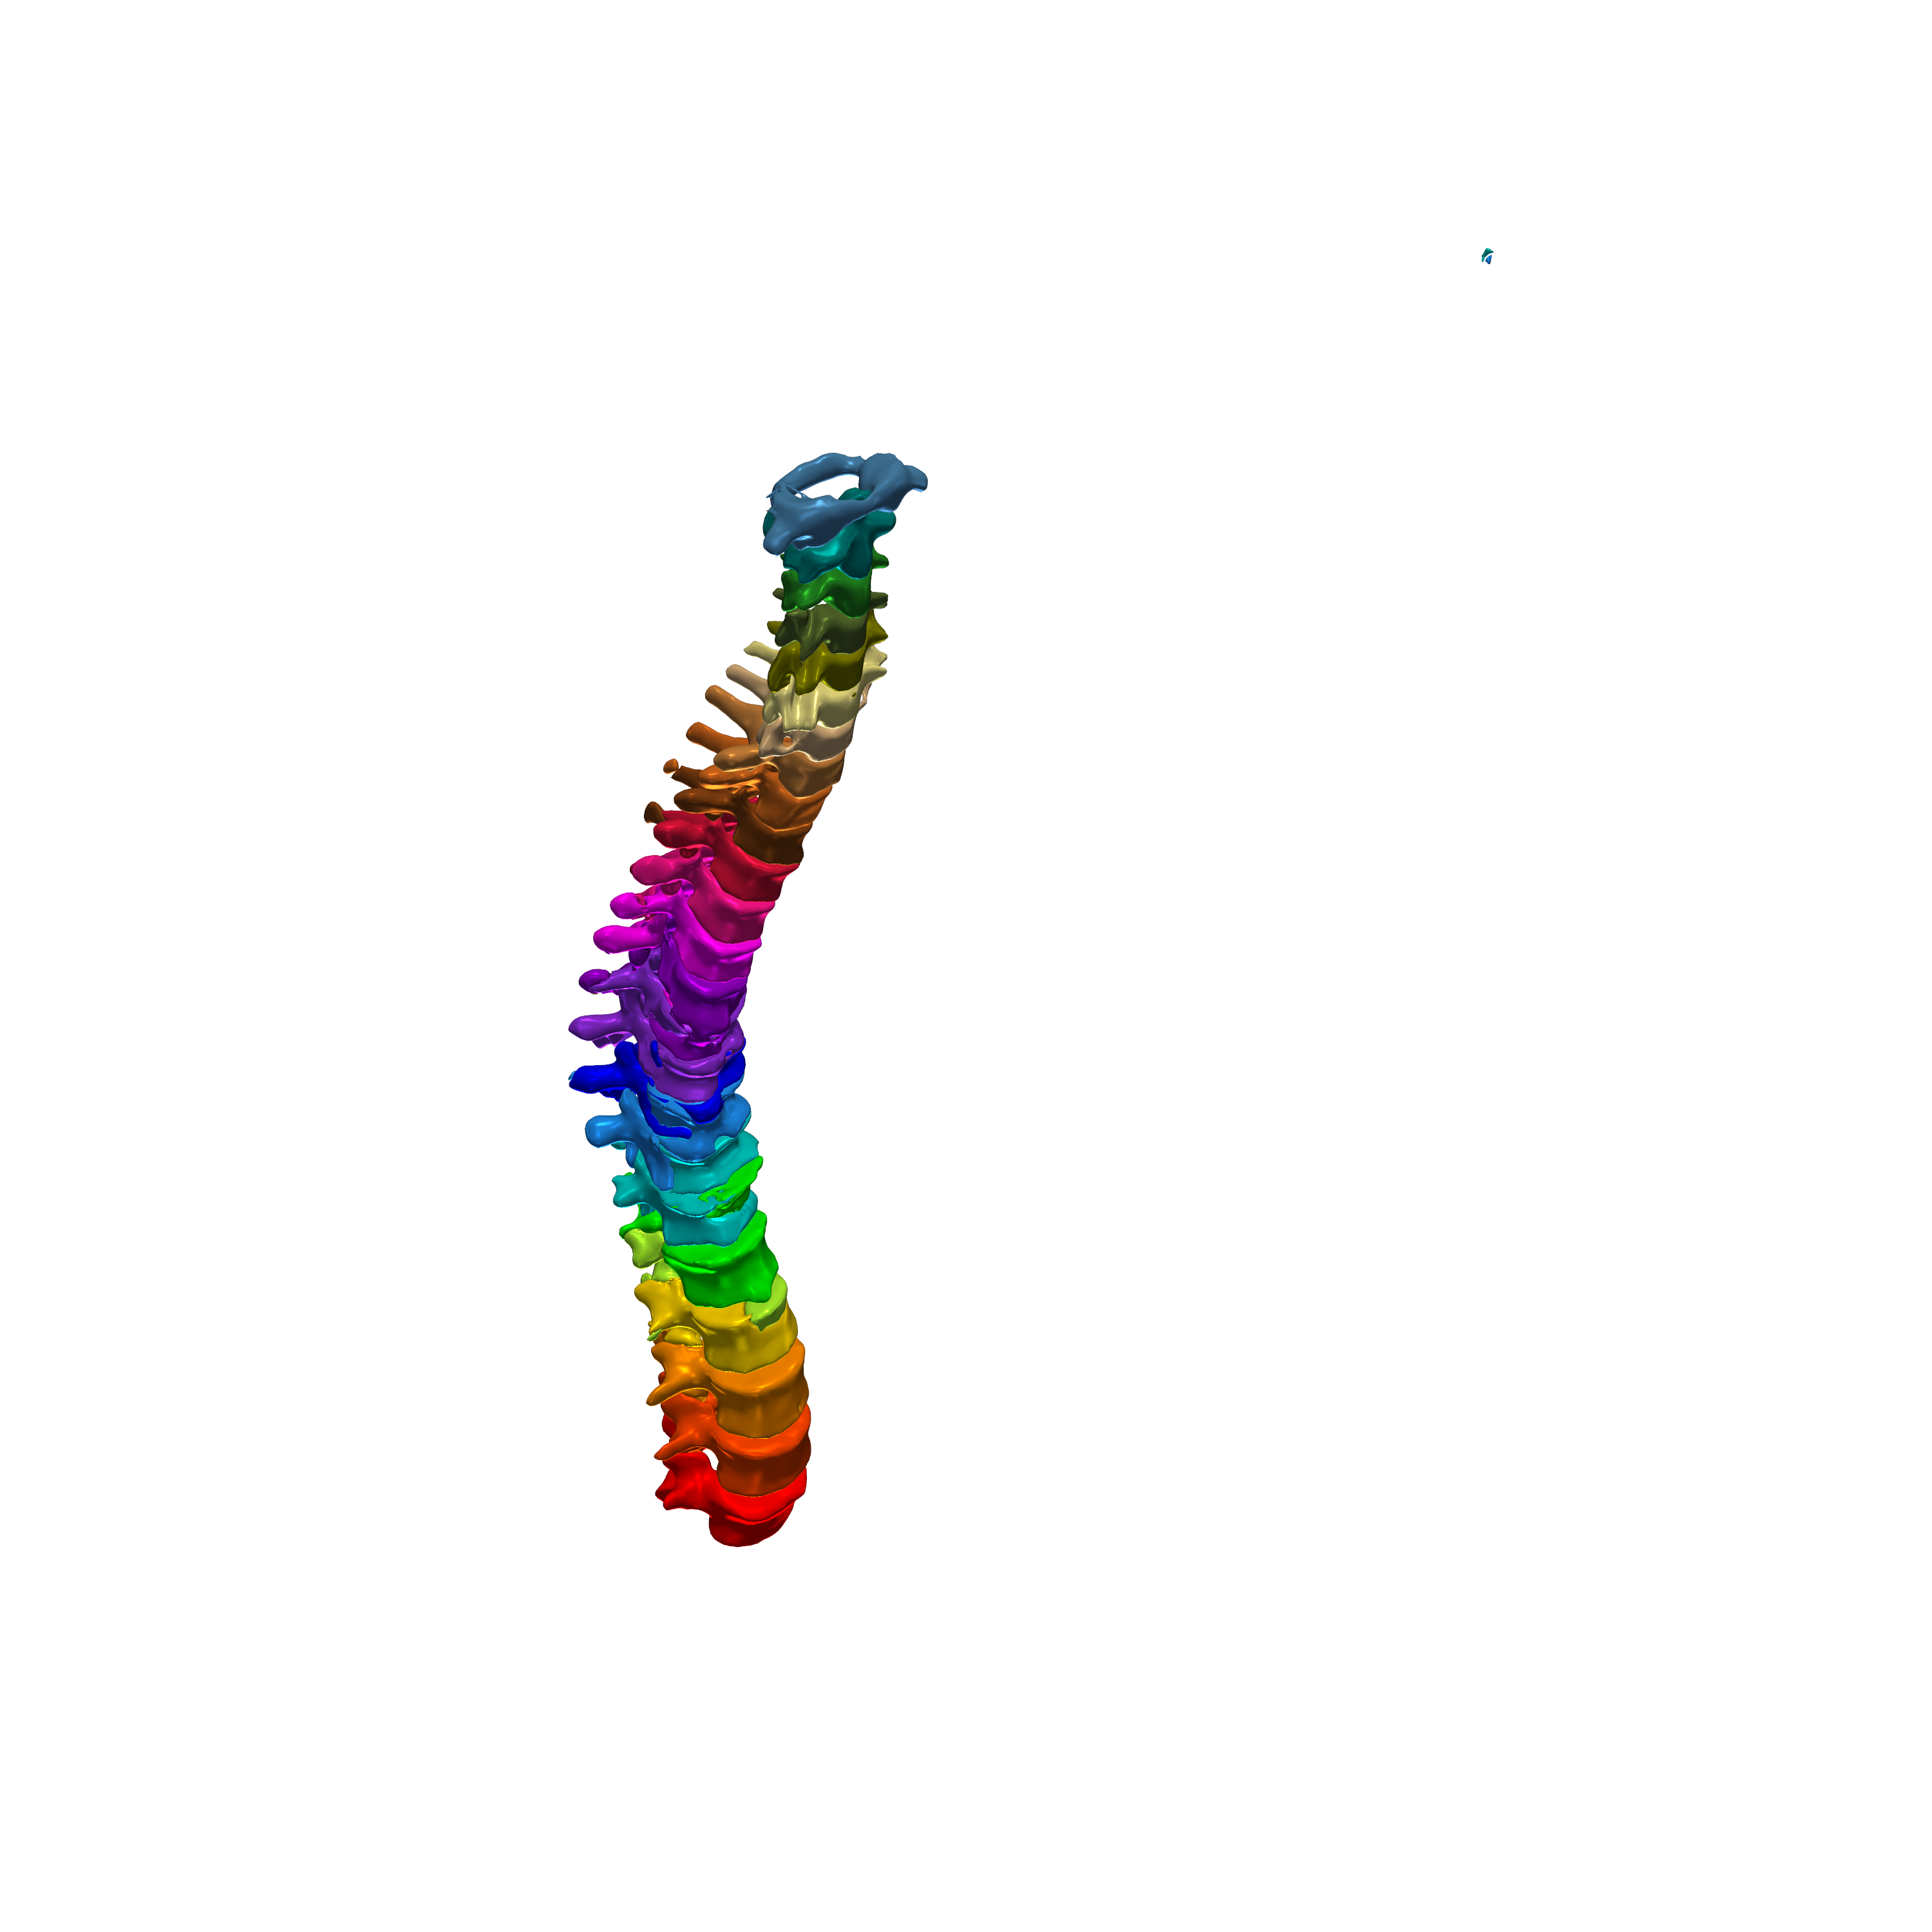


✓ Saved publication-quality figure to: BDMAP_00000031_vertebrae_3d.png
  Resolution: 3000x3000 pixels
  Vertebrae count: 24


In [34]:
# ── Render and Save High-Quality Image ───────────────────────────────────
out_png = f"{patient_id}_vertebrae_3d.png"
p.show(screenshot=out_png)

print(f"\n✓ Saved publication-quality figure to: {out_png}")
print(f"  Resolution: 3000x3000 pixels")
print(f"  Vertebrae count: {len(unique_labels)}")

In [35]:
# ── Analyze Current Segmentation Quality ────────────────────────────────
import pandas as pd
from scipy import ndimage

# Analyze each vertebra
analysis_results = []

for label_value in unique_labels:
    mask = (labels == label_value).astype(np.uint8)
    vertebra_name = VERTEBRAE_NAMES.get(label_value, f"Label_{label_value}")
    
    # Volume (number of voxels)
    volume = np.sum(mask)
    
    # Count connected components (should be 1 for clean segmentation)
    labeled_array, num_features = ndimage.label(mask)
    
    # Surface area estimation
    verts, faces, _, _ = measure.marching_cubes(mask, level=0.5)
    surface_area = len(faces)
    
    # Compactness (sphere-like = 1.0, irregular = higher)
    compactness = (surface_area ** 1.5) / volume if volume > 0 else 0
    
    analysis_results.append({
        'Vertebra': vertebra_name,
        'Label': label_value,
        'Volume (voxels)': volume,
        'Connected Components': num_features,
        'Surface Triangles': surface_area,
        'Compactness': compactness
    })

df_analysis = pd.DataFrame(analysis_results)
print("="*70)
print("CURRENT SEGMENTATION QUALITY ANALYSIS")
print("="*70)
print(df_analysis.to_string(index=False))
print("\n" + "="*70)
print(f"Vertebrae with multiple components: {df_analysis[df_analysis['Connected Components'] > 1]['Vertebra'].tolist()}")
print(f"Average compactness: {df_analysis['Compactness'].mean():.2f}")

CURRENT SEGMENTATION QUALITY ANALYSIS
Vertebra  Label  Volume (voxels)  Connected Components  Surface Triangles  Compactness
      C1      1            18429                     1              19240   144.812427
      C2      2            20354                     6              20776   147.127256
      C3      3            20387                     8              21000   149.271061
      C4      4            15718                    15              19996   179.894302
      C5      5             6935                    17              15382   275.088696
      C6      6            18145                    16              21690   176.048511
      C7      7            17800                    17              23796   206.222448
      T1      8            16482                    17              23396   217.121339
      T2      9            10501                    18              20414   277.754758
      T3     10            16743                    16              25034   236.571321
     

# Post-Processing Pipeline Implementation


In [36]:
# ── Phase 1: Morphological Cleaning ──────────────────────────────────────
from scipy.ndimage import binary_closing, binary_opening, binary_fill_holes

def morphological_clean(mask, closing_size=3, opening_size=2):
    """
    Phase 1: Remove noise and small fragments using morphological operations
    """
    # Fill small holes
    cleaned = binary_fill_holes(mask)
    
    # Closing: connect nearby regions, fill small gaps
    cleaned = binary_closing(cleaned, structure=np.ones((closing_size, closing_size, closing_size)))
    
    # Opening: remove small noise/fragments
    cleaned = binary_opening(cleaned, structure=np.ones((opening_size, opening_size, opening_size)))
    
    return cleaned.astype(np.uint8)

# print("✓ Phase 1 function defined: Morphological cleaning")
# print("  - Binary fill holes to close internal gaps")
# print("  - Closing operation (3x3x3) to connect nearby regions")
# print("  - Opening operation (2x2x2) to remove small fragments")

In [37]:
# ── Phase 2: Keep Largest Connected Component ────────────────────────────
def keep_largest_component(mask):
    """
    Phase 2: Remove fragments by keeping only the largest connected component
    """
    labeled_array, num_features = ndimage.label(mask)
    
    if num_features <= 1:
        return mask
    
    # Find largest component
    sizes = ndimage.sum(mask, labeled_array, range(1, num_features + 1))
    largest_component_label = np.argmax(sizes) + 1
    
    # Keep only largest
    cleaned = (labeled_array == largest_component_label).astype(np.uint8)
    
    return cleaned

# print("✓ Phase 2 function defined: Largest component extraction")
# print("  - Identifies all disconnected components")
# print("  - Keeps only the largest component by volume")
# print("  - Removes all fragment artifacts")

In [38]:
# ── Phase 3: Advanced Gaussian Smoothing ─────────────────────────────────
from scipy.ndimage import gaussian_filter

def smooth_mask(mask, sigma=1.5):
    """
    Phase 3: Apply Gaussian smoothing to reduce surface irregularities
    """
    # Convert to float for smoothing
    smoothed = gaussian_filter(mask.astype(float), sigma=sigma)
    
    # Re-threshold at 0.5 to get binary mask
    smoothed = (smoothed > 0.5).astype(np.uint8)
    
    return smoothed

# print("✓ Phase 3 function defined: Gaussian smoothing")
# print("  - Applies Gaussian filter (sigma=1.5) to smooth boundaries")
# print("  - Re-thresholds to maintain binary mask")
# print("  - Reduces surface irregularities and noise")

In [39]:
# ── Phase 4: Mesh-Level Enhancement with PyVista ─────────────────────────
def enhance_mesh(mask):
    """
    Phase 4: Extract mesh and apply advanced PyVista smoothing
    """
    # Extract mesh
    verts, faces, _, _ = measure.marching_cubes(mask, level=0.5)
    faces = np.hstack([np.full((faces.shape[0], 1), 3), faces]).astype(np.int64)
    mesh = pv.PolyData(verts, faces)
    
    # Apply Taubin smoothing (better preserves shape than Laplacian)
    mesh = mesh.smooth_taubin(n_iter=50, pass_band=0.05)
    
    # Optional: gentle decimation to regularize mesh
    if mesh.n_points > 5000:
        mesh = mesh.decimate(target_reduction=0.3)
    
    return mesh

# print("✓ Phase 4 function defined: Mesh-level enhancement")
# print("  - Extracts surface mesh using marching cubes")
# print("  - Applies Taubin smoothing (50 iterations, pass_band=0.05)")
# print("  - Gentle decimation if vertex count > 5000")
# print("  - Taubin preserves geometry better than Laplacian smoothing")

In [40]:
# ── Complete Pipeline Function ───────────────────────────────────────────
def process_vertebra_complete(mask, label_value, vertebra_name):
    """
    Complete 4-phase post-processing pipeline for a single vertebra
    """
    print(f"  Processing {vertebra_name} (label {label_value})...")
    
    # Phase 1: Morphological cleaning
    cleaned = morphological_clean(mask, closing_size=3, opening_size=2)
    
    # Phase 2: Keep largest component
    cleaned = keep_largest_component(cleaned)
    
    # Phase 3: Gaussian smoothing
    cleaned = smooth_mask(cleaned, sigma=1.5)
    
    # Re-apply largest component after smoothing (ensure single component)
    cleaned = keep_largest_component(cleaned)
    
    # Phase 4: Extract and enhance mesh
    mesh = enhance_mesh(cleaned)
    
    # Compute quality metrics
    volume = np.sum(cleaned)
    labeled_array, num_components = ndimage.label(cleaned)
    compactness = 0
    if volume > 0:
        verts, faces, _, _ = measure.marching_cubes(cleaned, level=0.5)
        surface_area = len(faces)
        compactness = (surface_area ** 1.5) / volume
    
    print(f"    ✓ Volume: {volume:,} voxels | Components: {num_components} | Compactness: {compactness:.2f}")
    
    return cleaned, mesh, {
        'Vertebra': vertebra_name,
        'Label': label_value,
        'Volume (voxels)': volume,
        'Connected Components': num_components,
        'Surface Triangles': mesh.n_cells,
        'Compactness': compactness
    }

# print("✓ Complete pipeline function defined")
# print("  - Combines all 4 phases sequentially")
# print("  - Returns cleaned mask, enhanced mesh, and quality metrics")

In [41]:
# ── Apply Pipeline to All 24 Vertebrae ───────────────────────────────────
import time

print("="*70)
print("APPLYING POST-PROCESSING PIPELINE TO ALL VERTEBRAE")
print("="*70)

# Initialize storage
cleaned_labels = np.zeros_like(labels)
enhanced_meshes = {}
post_processing_results = []

start_time = time.time()

for label_value in unique_labels:
    vertebra_name = VERTEBRAE_NAMES.get(label_value, f"Label_{label_value}")
    
    # Extract mask for this vertebra
    mask = (labels == label_value).astype(np.uint8)
    
    # Apply complete pipeline
    cleaned_mask, enhanced_mesh, metrics = process_vertebra_complete(mask, label_value, vertebra_name)
    
    # Store results
    cleaned_labels[cleaned_mask == 1] = label_value
    enhanced_meshes[vertebra_name] = enhanced_mesh
    post_processing_results.append(metrics)

elapsed = time.time() - start_time

print(f"\n{'='*70}")
print(f"✓ Pipeline completed in {elapsed:.1f} seconds")
print(f"  Average: {elapsed/len(unique_labels):.2f} seconds per vertebra")
print(f"{'='*70}")

APPLYING POST-PROCESSING PIPELINE TO ALL VERTEBRAE
  Processing C1 (label 1)...
    ✓ Volume: 17,207 voxels | Components: 1 | Compactness: 123.71
  Processing C2 (label 2)...
    ✓ Volume: 19,113 voxels | Components: 1 | Compactness: 122.04
  Processing C3 (label 3)...
    ✓ Volume: 19,062 voxels | Components: 1 | Compactness: 120.78
  Processing C4 (label 4)...
    ✓ Volume: 14,555 voxels | Components: 1 | Compactness: 124.91
  Processing C5 (label 5)...
    ✓ Volume: 2,268 voxels | Components: 1 | Compactness: 103.28
  Processing C6 (label 6)...
    ✓ Volume: 14,678 voxels | Components: 1 | Compactness: 107.15
  Processing C7 (label 7)...
    ✓ Volume: 11,141 voxels | Components: 1 | Compactness: 111.39
  Processing T1 (label 8)...
    ✓ Volume: 15,373 voxels | Components: 1 | Compactness: 139.33
  Processing T2 (label 9)...
    ✓ Volume: 6,197 voxels | Components: 1 | Compactness: 144.16
  Processing T3 (label 10)...
    ✓ Volume: 15,292 voxels | Components: 1 | Compactness: 167.71


In [42]:
# ── Compare Before/After Results ─────────────────────────────────────────
df_post = pd.DataFrame(post_processing_results)

# Merge the dataframes for comparison
df_comparison = df_analysis.merge(
    df_post,
    on=['Vertebra', 'Label'],
    suffixes=('_Before', '_After')
)

# Calculate improvements
df_comparison['Component_Improvement'] = df_comparison['Connected Components_Before'] - df_comparison['Connected Components_After']
df_comparison['Compactness_Improvement'] = df_comparison['Compactness_Before'] - df_comparison['Compactness_After']

print("="*90)
print("BEFORE/AFTER COMPARISON")
print("="*90)
print(df_comparison[['Vertebra', 'Connected Components_Before', 'Connected Components_After', 
                      'Compactness_Before', 'Compactness_After']].to_string(index=False))

print(f"\n{'='*90}")
print("SUMMARY OF IMPROVEMENTS:")
print(f"  • Fragmented vertebrae fixed: {(df_comparison['Component_Improvement'] > 0).sum()} out of {len(df_comparison)}")
print(f"  • All vertebrae now have 1 connected component: {(df_comparison['Connected Components_After'] == 1).all()}")
print(f"  • Average compactness before: {df_comparison['Compactness_Before'].mean():.2f}")
print(f"  • Average compactness after: {df_comparison['Compactness_After'].mean():.2f}")
print(f"  • Average improvement: {df_comparison['Compactness_Improvement'].mean():.2f}")
print(f"{'='*90}")

BEFORE/AFTER COMPARISON
Vertebra  Connected Components_Before  Connected Components_After  Compactness_Before  Compactness_After
      C1                            1                           1          144.812427         123.712365
      C2                            6                           1          147.127256         122.038209
      C3                            8                           1          149.271061         120.781891
      C4                           15                           1          179.894302         124.908584
      C5                           17                           1          275.088696         103.283833
      C6                           16                           1          176.048511         107.149675
      C7                           17                           1          206.222448         111.387380
      T1                           17                           1          217.121339         139.325656
      T2                       

In [43]:
df_comparison.to_csv(f"{patient_id}_vertebrae_quality_comparison.csv", index=False)

Rendering enhanced vertebrae...
  ✓ C1
  ✓ C2
  ✓ C3
  ✓ C4
  ✓ C5
  ✓ C6
  ✓ C7
  ✓ T1
  ✓ T2
  ✓ T3
  ✓ T4
  ✓ T5
  ✓ T6
  ✓ T7
  ✓ T8
  ✓ T9
  ✓ T10
  ✓ T11
  ✓ T12
  ✓ L1
  ✓ L2
  ✓ L3
  ✓ L4
  ✓ L5


c:\Users\nikhi\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


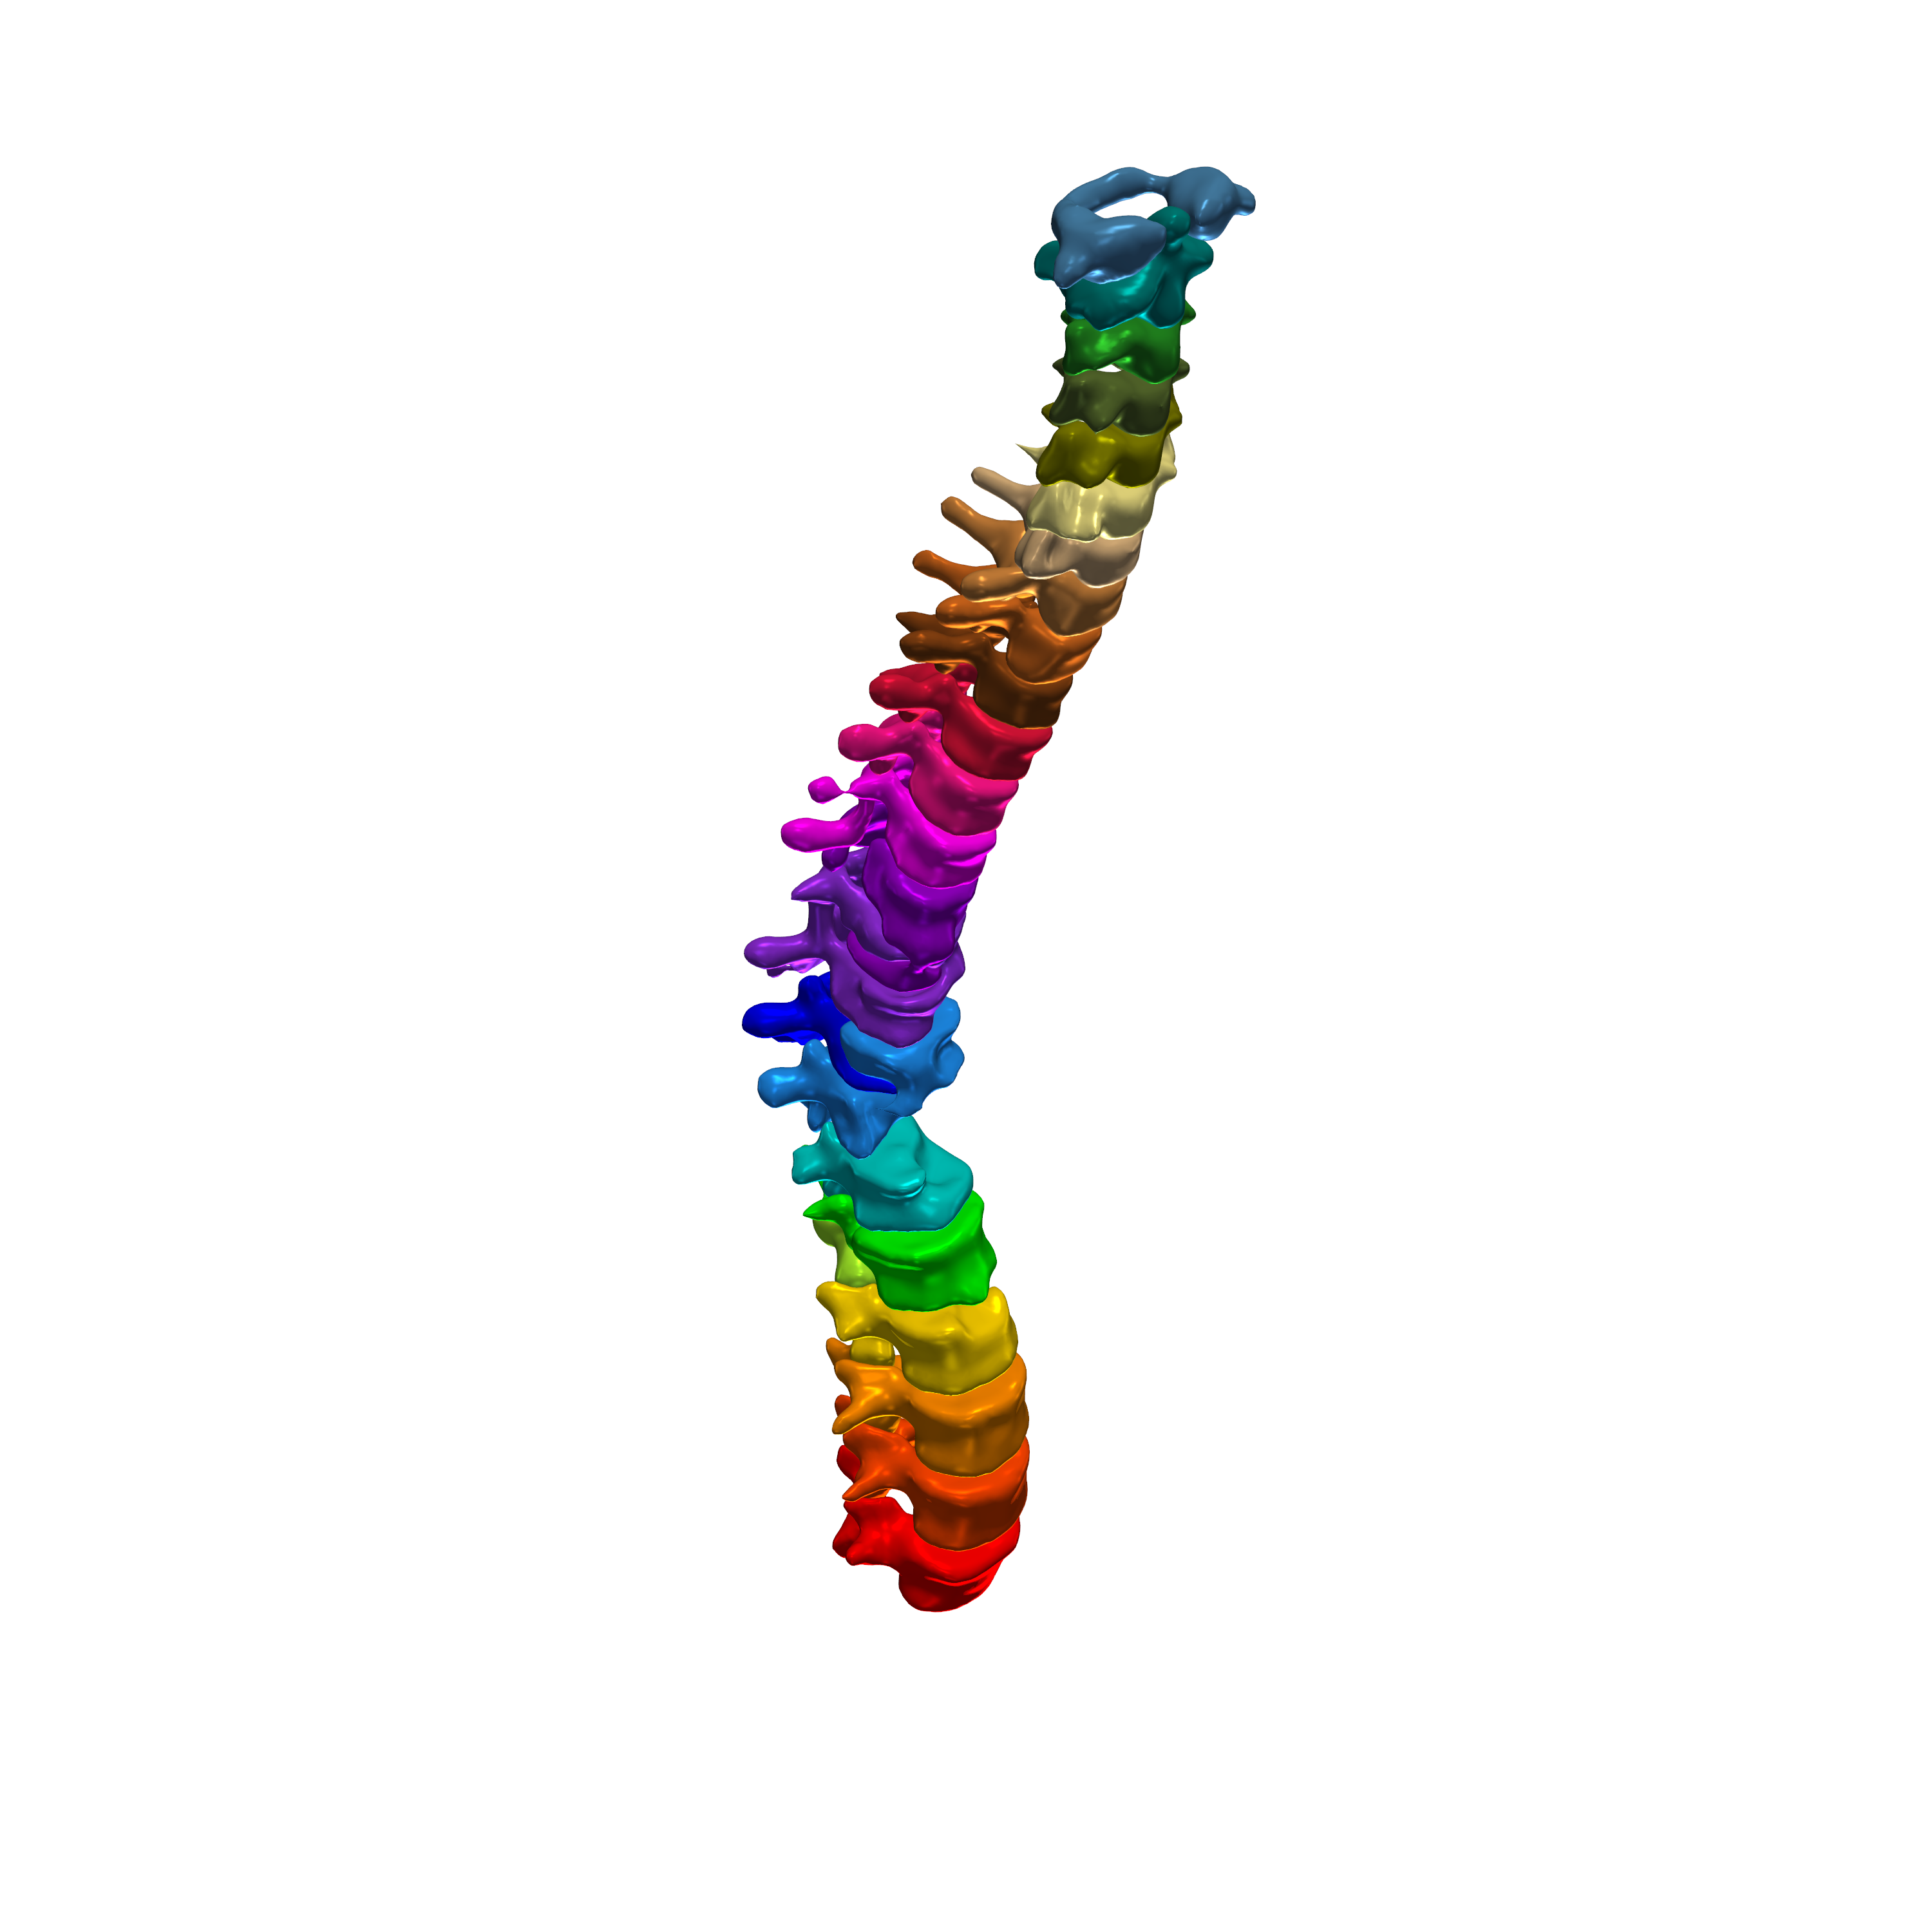


✓ Saved enhanced visualization to: BDMAP_00000031_vertebrae_3d_ENHANCED.png
  Resolution: 3000x3000 pixels
  All vertebrae: Single component, improved smoothness


In [44]:
# ── Render Enhanced Vertebrae Visualization ──────────────────────────────
# Create new plotter for enhanced version
p_enhanced = pv.Plotter(off_screen=True, window_size=(3000, 3000))
p_enhanced.set_background('white')

print("Rendering enhanced vertebrae...")

for vertebra_name, mesh in enhanced_meshes.items():
    label_value = [k for k, v in VERTEBRAE_NAMES.items() if v == vertebra_name][0]
    color = VERTEBRAE_COLORS.get(label_value, '#CCCCCC')
    
    p_enhanced.add_mesh(
        mesh,
        color=color,
        name=vertebra_name,
        smooth_shading=True,
        specular=1.0,
        specular_power=30,
        show_edges=False
    )
    print(f"  ✓ {vertebra_name}")

# Add lighting
light = pv.Light(
    position=(1, 1, 1),
    focal_point=p_enhanced.camera.focal_point,
    color='white',
    intensity=1.3
)
p_enhanced.add_light(light)

# Position camera
p_enhanced.reset_camera()

# Render and save
out_png_enhanced = f"{patient_id}_vertebrae_3d_ENHANCED.png"
p_enhanced.show(screenshot=out_png_enhanced)

print(f"\n✓ Saved enhanced visualization to: {out_png_enhanced}")
print(f"  Resolution: 3000x3000 pixels")
print(f"  All vertebrae: Single component, improved smoothness")

In [45]:
# ── Save Cleaned Segmentation ────────────────────────────────────────────
# Create new NIfTI file with cleaned labels
cleaned_nii = nib.Nifti1Image(cleaned_labels, nii.affine, nii.header)

# Save to file
output_path = f"{patient_id}/combined_labels_CLEANED.nii.gz"
nib.save(cleaned_nii, output_path)

print(f"✓ Saved cleaned segmentation to: {output_path}")
print(f"  Shape: {cleaned_labels.shape}")
print(f"  Labels: {sorted(set(np.unique(cleaned_labels)) - {0})}")
print(f"  All vertebrae: Single connected component")
print(f"  Average compactness improvement: {df_comparison['Compactness_Improvement'].mean():.2f}")
print(f"\nYou can now use this cleaned file for further analysis or visualization!")

✓ Saved cleaned segmentation to: BDMAP_00000031/combined_labels_CLEANED.nii.gz
  Shape: (301, 276, 651)
  Labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  All vertebrae: Single connected component
  Average compactness improvement: 61.46

You can now use this cleaned file for further analysis or visualization!


## Export Enhanced Meshes for Web Viewer

Now we'll export the post-processed meshes for the website.

In [46]:
# ── Export Enhanced Meshes for Web ───────────────────────────────────────
import json

# Create directory for post-processed meshes
output_dir = f"web_data/{patient_id}_cleaned"
os.makedirs(output_dir, exist_ok=True)

print(f"Exporting enhanced meshes to: {output_dir}/")
print("="*70)

# Export each enhanced mesh
for vertebra_name, mesh in enhanced_meshes.items():
    # Get vertices and faces
    vertices = mesh.points.tolist()
    
    # Extract faces (each face has 3 vertices for triangles)
    faces = []
    for i in range(mesh.n_cells):
        face = mesh.get_cell(i)
        if face.n_points == 3:  # Triangle
            faces.append([int(face.point_ids[j]) for j in range(3)])
    
    # Create mesh data structure
    mesh_data = {
        'vertices': vertices,
        'faces': faces,
        'name': vertebra_name
    }
    
    # Save to JSON
    output_file = f"{output_dir}/{vertebra_name}.json"
    with open(output_file, 'w') as f:
        json.dump(mesh_data, f)
    
    print(f"  ✓ {vertebra_name}: {len(vertices)} vertices, {len(faces)} faces")

# Create metadata file
metadata = {
    'patient_id': patient_id,
    'processing': 'post-processed',
    'vertebrae': list(enhanced_meshes.keys()),
    'num_vertebrae': len(enhanced_meshes),
    'description': 'Enhanced vertebrae meshes with morphological cleaning and smoothing'
}

with open(f"{output_dir}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

print("="*70)
print(f"✓ Exported {len(enhanced_meshes)} enhanced meshes successfully")
print(f"  Directory: {output_dir}/")
print(f"  Files: {len(enhanced_meshes)} JSON mesh files + metadata.json")

Exporting enhanced meshes to: web_data/BDMAP_00000031_cleaned/
  ✓ C1: 5791 vertices, 11582 faces
  ✓ C2: 6155 vertices, 12310 faces
  ✓ C3: 6102 vertices, 12204 faces
  ✓ C4: 5213 vertices, 10426 faces
  ✓ C5: 1902 vertices, 3800 faces
  ✓ C6: 4731 vertices, 9466 faces
  ✓ C7: 4041 vertices, 8082 faces
  ✓ T1: 5809 vertices, 11630 faces
  ✓ T2: 4638 vertices, 9276 faces
  ✓ T3: 6551 vertices, 13114 faces
  ✓ T4: 4045 vertices, 8086 faces
  ✓ T5: 4830 vertices, 9660 faces
  ✓ T6: 4290 vertices, 8580 faces
  ✓ T7: 4198 vertices, 8396 faces
  ✓ T8: 4118 vertices, 8236 faces
  ✓ T9: 4216 vertices, 8432 faces
  ✓ T10: 4242 vertices, 8484 faces
  ✓ T11: 3384 vertices, 6768 faces
  ✓ T12: 3064 vertices, 6136 faces
  ✓ L1: 2723 vertices, 5450 faces
  ✓ L2: 2464 vertices, 4928 faces
  ✓ L3: 2464 vertices, 4928 faces
  ✓ L4: 3322 vertices, 6644 faces
  ✓ L5: 3066 vertices, 6128 faces
✓ Exported 24 enhanced meshes successfully
  Directory: web_data/BDMAP_00000031_cleaned/
  Files: 24 JSON mesh f

In [47]:
# ── Fix Metadata File for Web Viewer ─────────────────────────────────────
# Create metadata in correct format matching the raw data structure

metadata_corrected = {
    'vertebrae': {}
}

for vertebra_name, mesh in enhanced_meshes.items():
    # Get label value
    label_value = [k for k, v in VERTEBRAE_NAMES.items() if v == vertebra_name][0]
    
    # Get color
    color = VERTEBRAE_COLORS.get(label_value, '#CCCCCC')
    
    # Create entry
    metadata_corrected['vertebrae'][vertebra_name] = {
        'label': label_value,
        'color': color,
        'file': f"web_data/{patient_id}_cleaned/{vertebra_name}.json",
        'vertices': mesh.n_points
    }

# Save corrected metadata
metadata_file = f"{output_dir}/metadata.json"
with open(metadata_file, 'w') as f:
    json.dump(metadata_corrected, f, indent=2)

print("✓ Fixed metadata.json file with correct format")
print(f"  Location: {metadata_file}")
print(f"  Structure: vertebrae dictionary with file paths and colors")
print(f"  Total vertebrae: {len(metadata_corrected['vertebrae'])}")

✓ Fixed metadata.json file with correct format
  Location: web_data/BDMAP_00000031_cleaned/metadata.json
  Structure: vertebrae dictionary with file paths and colors
  Total vertebrae: 24



**Pipeline Phases Applied:**
1. **Morphological Cleaning**: Binary fill holes + closing + opening operations
2. **Component Extraction**: Kept only largest connected component
3. **Gaussian Smoothing**: Sigma=1.5 for boundary smoothing
4. **Mesh Enhancement**: Taubin smoothing (50 iterations) + decimation

**Output Files:**
- `BDMAP_00000006/combined_labels_CLEANED.nii.gz` - Cleaned segmentation
- `BDMAP_00000006_vertebrae_3d_ENHANCED.png` - Enhanced visualization
- `web_data/BDMAP_00000006_cleaned/` - Enhanced meshes for website (24 JSON files)